# Exercise 2
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 3 Data Preparation
We want $\frac{train}{test} = \frac{3}{2}$ and $train + test = 1$, ergo $test = 0.4$.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# filter to 1s and 7s
os = np.logical_or(target==1, target==7)
data17 = data[os]
images17 = images[os]
target17 = target[os]

# for convenience, also define data1, data7, etc.
o = target == 1
data1 = data[o]
images1 = images[o]
target1 = target[o]

s = target == 7
data7 = data[s]
images7 = images[s]
target7 = target[s]


del o
del s
del os

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data17, target17, test_size=0.4, random_state=0
)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


### 3.1 Dimension Reduction

In theory, it would be a good idea to select features based on
the Fourier Transform of the data, since humans tend to distinguish
between digits by looking at the edges. However, we have found no significantly
defining feature in the FT from the plots (and some experimentation).
It is thus a better idea to select pixels from the original (untransformed) data.

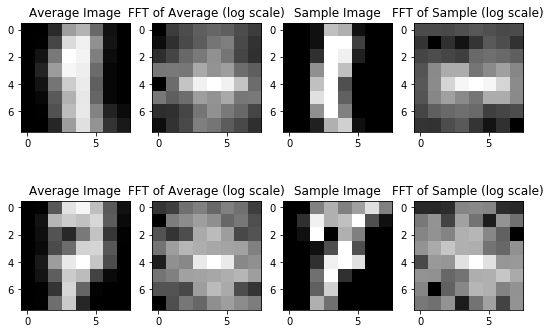

(2, 216)


In [2]:
digits = [1, 7]
n = len(digits)

fig, axes = plt.subplots(n, 4, figsize=(9, 3 * n))

for i, d in enumerate(digits):
    keep = target == d
    keep_images = images[keep]

    avg_img = np.mean(keep_images, axis=0)
    sample_img = keep_images[np.random.choice(keep_images.shape[0]), :, :]
    avg_fft = np.fft.fftshift(
        np.log(np.abs(np.fft.fft2(avg_img)) ** 2)
    )
    sample_fft = np.fft.fftshift(
        np.log(np.abs(np.fft.fft2(sample_img)) ** 2)
    )


    axes[i][0].imshow(avg_img, cmap="gray")
    axes[i][0].set_title("Average Image")
    axes[i][1].imshow(avg_fft, cmap="gray")
    axes[i][1].set_title("FFT of Average (log scale)")
    axes[i][2].imshow(sample_img, cmap="gray")
    axes[i][2].set_title("Sample Image")
    axes[i][3].imshow(sample_fft, cmap="gray")
    axes[i][3].set_title("FFT of Sample (log scale)")


plt.show()


def feature1(x):
    # pixel (2, 3) is brighter for ones
    idx = 2 * images.shape[1] + 3
    return x[:,idx]

def feature2(x):
    # pixel (7, 4) is also brighter for ones
    idx = 7 * images.shape[1] + 4
    return x[:, idx]


def reduce_dimensions(x):
    return np.stack([feature1(x), feature2(x)])


reduced_x = reduce_dimensions(x_train)

print(reduced_x.shape)

### 3.2 Scatterplot

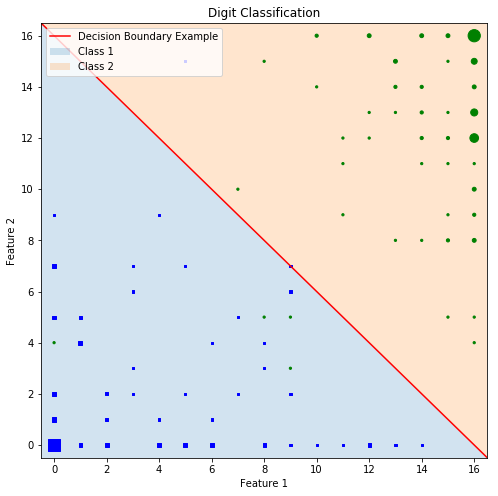

In [3]:
def line(x):
    return 16 - x

line_x = np.linspace(-5, 20, 1000)
line_y = line(line_x)

plt.figure(figsize=(8, 8))
plt.fill_between(line_x, -5, line_y, alpha=0.2, label="Class 1")
plt.fill_between(line_x, line_y, 20, alpha=0.2, label="Class 2")


unique_1, counts_1 = np.unique(reduced_x[:,y_train == 1], axis=1, return_counts=True)
unique_7, counts_7 = np.unique(reduced_x[:,y_train == 7], axis=1, return_counts=True)

plt.plot(line_x, line_y, label="Decision Boundary Example", color="red")
plt.scatter(unique_1[0], unique_1[1], s=5 * counts_1, color="green", marker="o")
plt.scatter(unique_7[0], unique_7[1], s=5 * counts_7, color="blue", marker="s")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-0.5, 16.5)
plt.ylim(-0.5, 16.5)
plt.title("Digit Classification")
plt.legend(loc="upper left")

plt.show()

## 4 Nearest Mean
### 4.1 Implement the nearest mean classifier

In [4]:
def distance(training, test):
    # from ex01b
    sums = np.sum(np.square(training)[:,np.newaxis,:], axis=2) - 2*training.dot(test.T) + np.sum(np.square(test), axis=1)
    return np.sqrt(sums)

def nearest_mean(training_features, training_labels, test_features):
    
    means = np.array([np.mean(training_features[:,training_labels == label], axis=1) for label in np.unique(training_labels)])
    predicted = np.unique(training_labels)[np.argmin(distance(means, test_features.T), axis=0)]
    return predicted

predicted = nearest_mean(reduced_x, y_train, reduce_dimensions(x_test))
print(np.mean(predicted != y_test))

0.006896551724137931


### 4.2 Visualize the decision regions

''

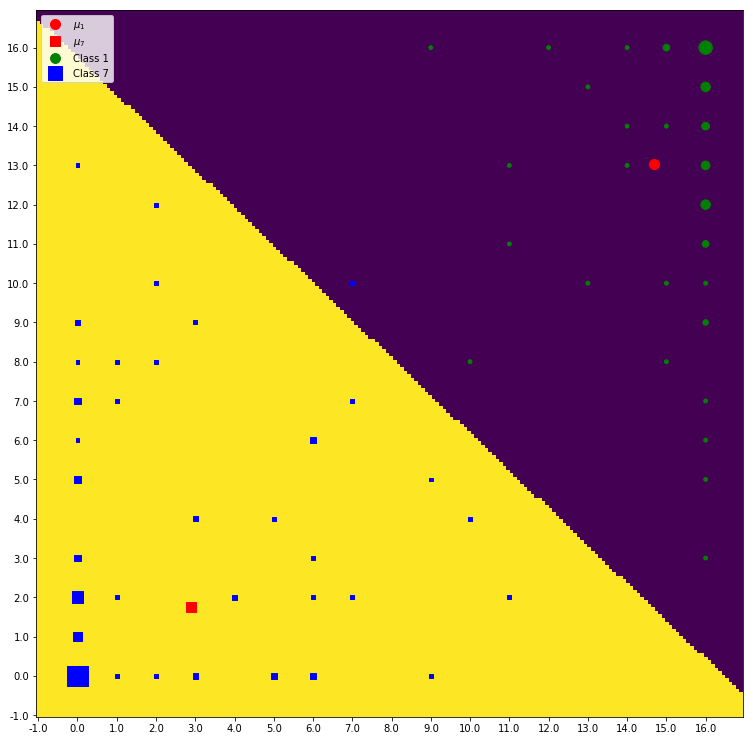

In [5]:
data = []
grid = np.array(np.meshgrid(np.linspace(-1,17,200), np.linspace(-1,17,200)))
for i in range(200):
    data.append(nearest_mean(reduced_x, y_train, grid[:,:,i]))

plt.figure(figsize=(13,13))
plt.imshow(np.array(data), interpolation='nearest', origin='lower')
reduced_x_test = reduce_dimensions(x_test)
unique_x_test_1, count_x_test_1 = np.unique(reduced_x_test[:,y_test == 1], axis=1, return_counts=True)
unique_x_test_7, count_x_test_7 = np.unique(reduced_x_test[:,y_test == 7], axis=1, return_counts=True)
plt.scatter((unique_x_test_1[0]+1)*200./18, (unique_x_test_1[1]+1)*200./18, s=15*count_x_test_1, color="green", marker="o", label="Class 1")
plt.scatter((unique_x_test_7[0]+1)*200./18, (unique_x_test_7[1]+1)*200./18, s=15*count_x_test_7, color="blue", marker="s", label="Class 7")
plt.xticks(np.linspace(0,200,19), np.linspace(-1,17,19))
plt.yticks(np.linspace(0,200,19), np.linspace(-1,17,19))

means = np.array([np.mean(reduced_x[:,y_train == label], axis=1) for label in np.unique(y_train)])
plt.plot((means[0, 0]+1)*200./18, (means[0, 1]+1)*200./18, "ro", markersize=10, label=r"$\mu_{1}$")
plt.plot((means[1, 0]+1)*200./18, (means[1, 1]+1)*200./18, "rs", markersize=10, label=r"$\mu_{7}$")

plt.legend(loc="upper left")
;

## 5 QDA
### 5.1 Implement QDA Training

In [6]:
def fit_qda(training_features, training_labels):
    # training_features.shape = N x D
    # training_labels.shape = N
    # N=#instances, D=#features (=2)
    
    # mu.shape = 2 x D
    # covmat.shape = 2 x D x D
    # p.shape = 2
    
    mu = np.array([np.mean(training_features[training_labels == label,:], axis=0) for label in np.unique(training_labels)])
    
    labels, counts = np.unique(training_labels, return_counts=True)
    covmat = []
    for k in range(len(labels)):
        features_k = training_features[training_labels == labels[k], :]
        d = features_k - mu[k]
        Sigma_k = d[:,None,:]*d[:,:,None]
        Sigma_k = np.sum(Sigma_k, axis=0) / counts[k]
        covmat.append(Sigma_k)
    covmat = np.array(covmat)
    p = counts / len(training_labels)
    
    return mu, covmat, p
    
mu, covmat, p = fit_qda(reduced_x.T, y_train)
print(mu.shape, covmat.shape, p.shape)
print(mu, "\n")
print(covmat, "\n")
print(p)

(2, 2) (2, 2, 2) (2,)
[[14.67479675 13.02439024]
 [ 2.89247312  1.75268817]] 

[[[ 5.92676317  2.53638707]
  [ 2.53638707 10.20265715]]

 [[13.62284657  0.47878367]
  [ 0.47878367  7.88507342]]] 

[0.56944444 0.43055556]


### 5.2 Implement QDA Prediction

In [7]:
def predict_qda(mu, covmat, p, test_features):
    # mu.shape = 2 x D
    # covmat.shape = 2 x D x D
    # p.shape = 2
    # test_features.shape = M x D
    
    Sigma_inverse = []
    b = []
    for Sigma_k, p_k in zip(covmat, p):
        Sigma_inverse.append(np.linalg.inv(Sigma_k))
        b.append(0.5*np.log(np.linalg.det(2*np.pi*Sigma_k)) - np.log(p_k))
    Sigma_inverse = np.array(Sigma_inverse)
    b = np.array(b)
    
    
    diff = test_features[:,np.newaxis,:] - mu
    prod = (diff[:,:,:,np.newaxis] * Sigma_inverse).sum(axis=3)
    res = (prod * diff).sum(axis=2)
    res = 0.5*res + b
    return np.argmin(res, axis=1)
    

predicted = predict_qda(mu, covmat, p, reduce_dimensions(x_test).T)
print(f"test error = \t{np.mean((predicted == 0) != (y_test == 1))}")


predicted = predict_qda(mu, covmat, p, reduce_dimensions(x_train).T)
print(f"train error = \t{np.mean((predicted == 0) != (y_train == 1))}")

test error = 	0.006896551724137931
train error = 	0.027777777777777776


### 5.3 Visualization

''

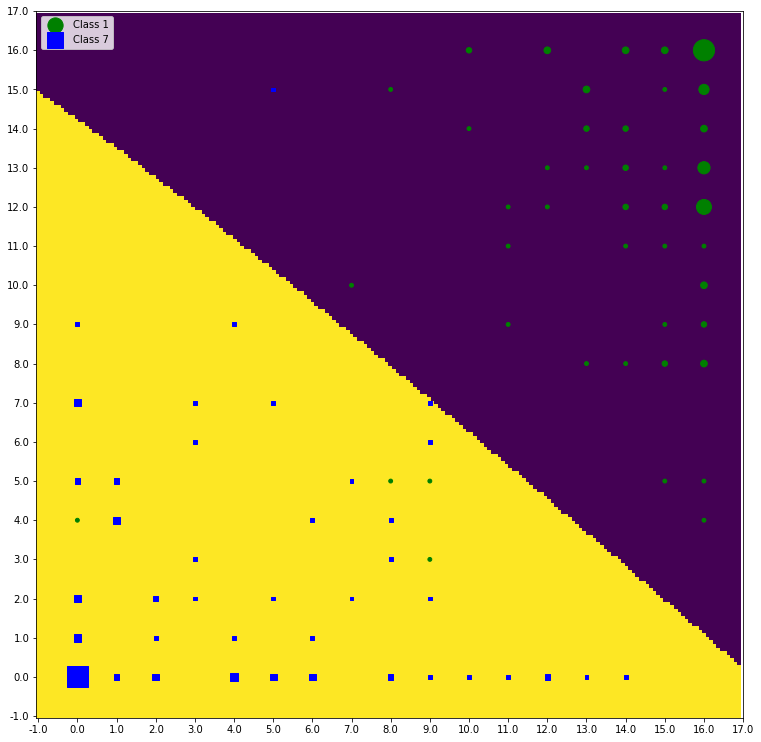

In [8]:
data = []
grid = np.array(np.meshgrid(np.linspace(-1,17,200), np.linspace(-1,17,200)))
for i in range(200):
    data.append(predict_qda(mu, covmat, p, grid[:,:,i].T))

plt.figure(figsize=(13,13))
plt.imshow(np.array(data), interpolation='nearest', origin='lower')
reduced_x_train = reduce_dimensions(x_train)
unique_x_train_1, count_x_train_1 = np.unique(reduced_x_train[:,y_train == 1], axis=1, return_counts=True)
unique_x_train_7, count_x_train_7 = np.unique(reduced_x_train[:,y_train == 7], axis=1, return_counts=True)
plt.scatter((unique_x_train_1[0]+1)*200./18, (unique_x_train_1[1]+1)*200./18, s=15*count_x_train_1, color="green", marker="o", label="Class 1")
plt.scatter((unique_x_train_7[0]+1)*200./18, (unique_x_train_7[1]+1)*200./18, s=15*count_x_train_7, color="blue", marker="s", label="Class 7")
plt.xticks(np.linspace(0,200,19), np.linspace(-1,17,19))
plt.yticks(np.linspace(0,200,19), np.linspace(-1,17,19))
plt.legend(loc="upper left")

;

### 5.4 Performance evaluation

## 6 LDA